# All Regression Notebook
## Load data
Declare and load the library, then load the dataset. Since the data do not contain the naming of columns, we had to add it in using a manual Python list

We will have `all_train_data` and `all_test_data`, which had been concatenated into their respective `DataFrame`.

In [23]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

columns_name = ["Popularity", "Check-in", "Activities", "Category"] \
            + ["F_{:d}".format(i) for i in range(1, 26)] \
            + ["CC{:d}".format(i) for i in range(1, 6)] \
            + ["Base time", "Post length", "Post count", "Post promotion", "Span time"] \
            + ["Post_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Base_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Span count"]
all_train_data = [pandas.read_csv("Dataset/Training/Features_Variant_{:d}.csv".format(d), header=None) for d in range(1, 6)]
# concatenate training data here
train_data = pandas.concat(all_train_data, axis=0, ignore_index=True)
train_data.columns = columns_name

all_test_data = [pandas.read_csv("Dataset/Testing/TestSet/Test_Case_{:d}.csv".format(d), header=None) for d in range(1, 10)]
# concatenate test_data here
test_data = pandas.concat(all_test_data, axis=0, ignore_index=True)
test_data.columns = columns_name

train_data["bias"] = 1
test_data["bias"] = 1

train_data.head()

,Popularity,Check-in,Activities,Category,F_1,F_2,F_3,F_4,F_5,F_6,...,Post_date_7,Base_date_1,Base_date_2,Base_date_3,Base_date_4,Base_date_5,Base_date_6,Base_date_7,Span count,bias
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,1
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,1,0,0,1
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,1
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,1,0,0,0,0,0,0,1
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,1,0,0,0,0,1


## Selecting sub-category
The Category column contain arbitrary indices of the data category relating to the nature of the post itself. For the sake of simplification, we will just use the category with the largest amount of data to perform our Linear regression on.

Find and select the category with the most amount of records using pandas. Store it in the variable `largest_category`

In [24]:
largest_category = train_data.Category.mode().values[0]

In [25]:
# Categorize models
train_data = train_data.loc[train_data['Category'] == largest_category].drop('Category', axis=1)
test_data = test_data.loc[test_data['Category'] == largest_category].drop('Category', axis=1)

label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

## A basic correlation
As a little exercise, we will draw a correlation matrix between CC? variables. Correlation are useful to see if there are features that are too closely connected - and we don't want those together as they will introduce artificial noises that will overfit the model.

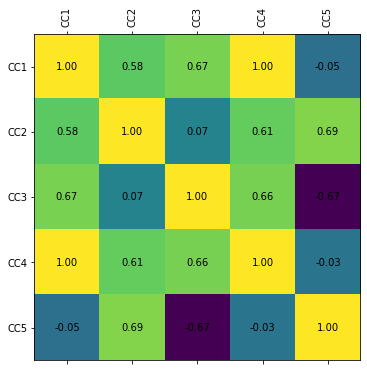

In [26]:
subdata = train_data[(col for col in train_data.columns if "CC" in col)]
correlation_matrix = subdata.corr()

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(correlation_matrix)

# this two lines may cause trouble with different versions of matplotlib. If it fail, try to delete and see.
plt.xticks(np.arange(len(correlation_matrix.columns)))
plt.yticks(np.arange(len(correlation_matrix.columns)))

ax.set_xticklabels(correlation_matrix.columns.values.tolist())
ax.set_yticklabels(correlation_matrix.columns.values.tolist())
plt.xticks(rotation=90)

for i, column in enumerate(correlation_matrix.values):
    for j, value in enumerate(column):
        text = ax.text(j, i, "%.2f" % value,
                       ha="center", va="center", color="black")
plt.show()

## Build Regression Models

__Our task is to predict the number of comments the post will receive ("Span count" column)__ <br>
"Span time" is necessary, while all other columns are optional <br>
Try a simple Multiple Regression model with only the basic features: <br>
["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"] <br>

Print out either the MSE score from sklearn or the RSS score learned from the course for both training and testing dataset

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# prepare data
features = ["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]
label = "Span count"
train_features = scaler.fit_transform(train_data[features].values)
train_labels = train_data[label].values

test_features = scaler.transform(test_data[features].values)
test_labels = test_data[label].values
# predict
multi_model = LinearRegression().fit(train_features, train_labels)
test_predictions= multi_model.predict(test_features)
mse_train = mean_squared_error(train_labels, multi_model.predict(train_features))
mse_test = mean_squared_error(test_labels, multi_model.predict(test_features))
print("Train MSE: {:.4f}, Test MSE: {:.4f}".format(mse_train, mse_test))

Train MSE: 1689.5665, Test MSE: 5340.5897


### Try improving with more features
Not the greatest model we could use. We should try to add even more relevant features. <br>Append all the CC properties to the features and try again, with the same metrics.

In [28]:
scaler = StandardScaler()
features_add_cc = [col for col in train_data.columns if "CC" in col]
train_features = scaler.fit_transform(train_data[features_add_cc].values)
multi_model = LinearRegression().fit(train_features, train_labels)

test_features = scaler.transform(test_data[features_add_cc].values)
test_predictions= multi_model.predict(test_features)
mse_train = mean_squared_error(train_labels, multi_model.predict(train_features))
mse_test = mean_squared_error(test_labels, multi_model.predict(test_features))
print("Train MSE: {:.4f}, Test MSE: {:.4f}".format(mse_train, mse_test))

Train MSE: 1659.5517, Test MSE: 4040.9943


Moral of the day: Premature optimization are rarely ever worth it.

## Resolve overfit
### Applying resolution for overfit

The discrepancy between the score of the training and testing indicate that we may be overfitting the model. Let's try to fix it. Span the Ridge regression with alpha along logspace between 0 and 10, record the value with the best performance as variable `best_alpha`, and *optionally draw a graph for the coefficients magnitude*.

In [29]:
from sklearn.linear_model import Ridge
l2_alphas = np.logspace(0, 10)
mses = []
coefs = []

for l2_alpha in l2_alphas:
    multi_model = Ridge(alpha=l2_alpha).fit(train_features, train_labels)
    mses.append(mean_squared_error(test_labels, multi_model.predict(test_features)))
    coefs.append(multi_model.coef_)
best_alpha = l2_alphas[np.argmin(mses)]

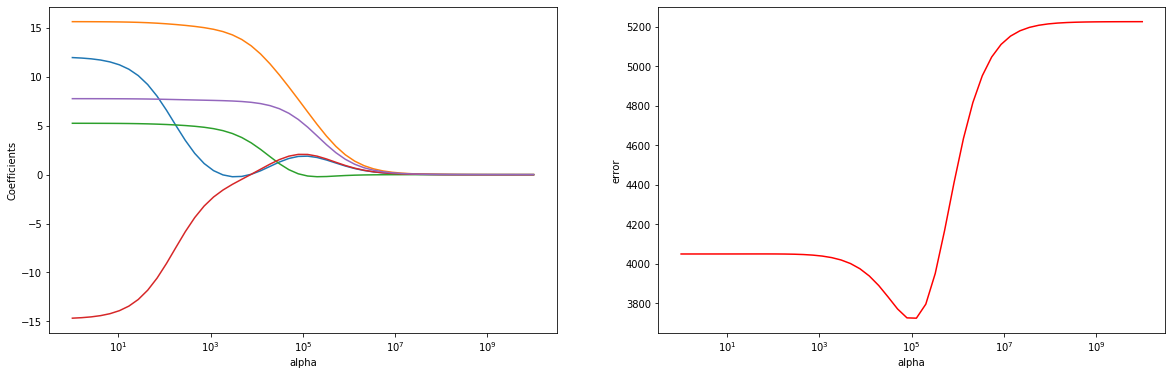

In [30]:
# display size
plt.figure(figsize=(20, 6))
plt.subplot(121)
ax = plt.gca()
ax.plot(l2_alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("Coefficients")
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(l2_alphas, mses, color='red')
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("error")
plt.axis('tight')
plt.show()

### Try Ridge Regression on every columns
It worked, but one have to wonder if we are still using the incomplete set of features instead of the optimal one. Expand the features to all columns except our designated label. Run and see what happens.

In [31]:
label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
test_features = test_data[ features ]

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)
multi_model = Ridge(alpha=best_alpha).fit(train_features, train_labels)
test_predictions = multi_model.predict(test_features)
mse_test = mean_squared_error(test_labels, test_predictions)
mse_train = mean_squared_error(train_labels, multi_model.predict(train_features))
print("Train MSE: {:.4f}, Test MSE: {:.4f}".format(mse_train, mse_test))

Train MSE: 1585.6892, Test MSE: 3913.7745


## Features selection
### Apply LASSO
Now, we can try trimming the features using something we had learned throughout the course. This time record the selected features of LASSO using variable `lasso_selected_features`, and <i>optionally draw a graph between number of removed features and alpha values</i>.

In [32]:
# this is requirement what i understand, get the features where model gets the smallest MSE on test data
# this takes about 13 seconds, depending on your PC environment
from sklearn.linear_model import Lasso
number_of_features_remain = []
features_coef_remain = []
l1_alphas = np.logspace(-4, 2, 5)
mses = []

for l1_alpha in l1_alphas:
    multi_model = Lasso(alpha=l1_alpha).fit(train_features, train_labels)
    mses.append(mean_squared_error(test_labels,multi_model.predict(test_features)))
    features_coef_remain.append(multi_model.coef_)
    number_of_features_remain.append(np.count_nonzero(multi_model.coef_))

/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81750799.03742334, tolerance: 22536.646697948156
  positive)
/home/leanh/anaconda3/envs/ml-301x/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42618002.93311011, tolerance: 22536.646697948156
  positive)


In [33]:
best_model_coefs = features_coef_remain[np.argmin(mses)]
lasso_selected_features = np.array(features)[best_model_coefs != 0].tolist()
l1_first = l1_alphas[np.argmin(mses)]
print("MSE: {:.4f}\nLasso selected features first: {}\nAlpha: {:.4f}".format(min(mses), lasso_selected_features, l1_first))

MSE: 3863.9978
Lasso selected features first: ['F_8', 'F_9', 'CC2', 'CC5', 'Base time', 'Post count']
Alpha: 3.1623


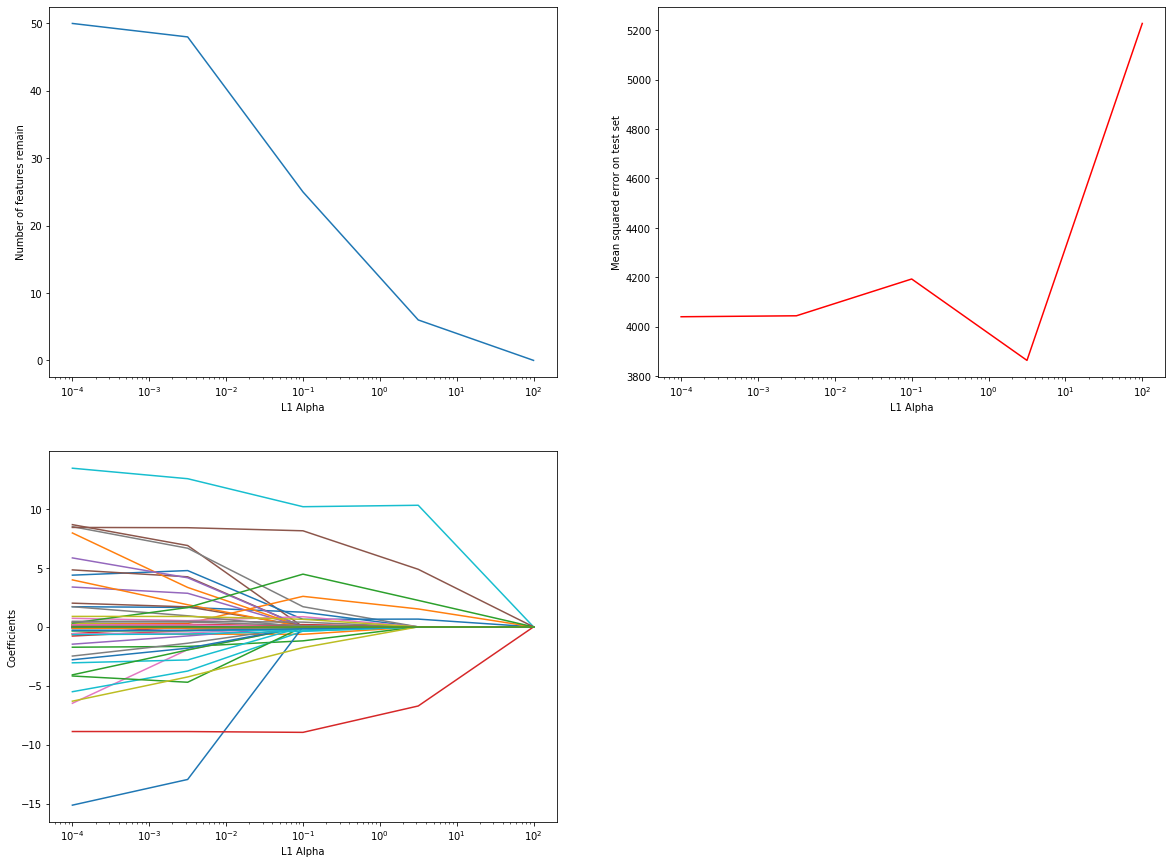

In [34]:
plt.figure(figsize=(20, 15))
plt.subplot(221)
plt.plot(l1_alphas, number_of_features_remain)
plt.xscale("log")
plt.xlabel("L1 Alpha")
plt.ylabel("Number of features remain")
plt.axis('tight')

plt.subplot(222)
plt.plot(l1_alphas, mses, color="red")
plt.xscale("log")
plt.xlabel("L1 Alpha")
plt.ylabel("Mean squared error on test set")
plt.axis('tight')

plt.subplot(223)
plt.plot(l1_alphas, features_coef_remain)
plt.xscale("log")
plt.xlabel("L1 Alpha")
plt.ylabel("Coefficients")
plt.axis('tight')
plt.show()

In [35]:
# deep dive into smaller range
number_of_features_remain = []
features_coef_remain = []
l1_alphas = np.linspace(l1_first/2, l1_first*2)
mses = []

for l1_alpha in l1_alphas:
    multi_model = Lasso(alpha=l1_alpha).fit(train_features, train_labels)
    mses.append(mean_squared_error(test_labels, multi_model.predict(test_features)))
    features_coef_remain.append(multi_model.coef_)
    number_of_features_remain.append(np.count_nonzero(multi_model.coef_))

In [36]:
# get some info
best_model_coefs = features_coef_remain[np.argmin(mses)]
lasso_selected_features = np.array(features)[best_model_coefs != 0].tolist()
best_l1_alpha = l1_alphas[np.argmin(mses)]
print("MSE: {:.4f}\nLasso selected features seconde: {}\nAlpha: {:.4f}".format(min(mses), lasso_selected_features, best_l1_alpha))

MSE: 3660.8884
Lasso selected features seconde: ['CC2', 'Base time', 'Post count']
Alpha: 5.6469


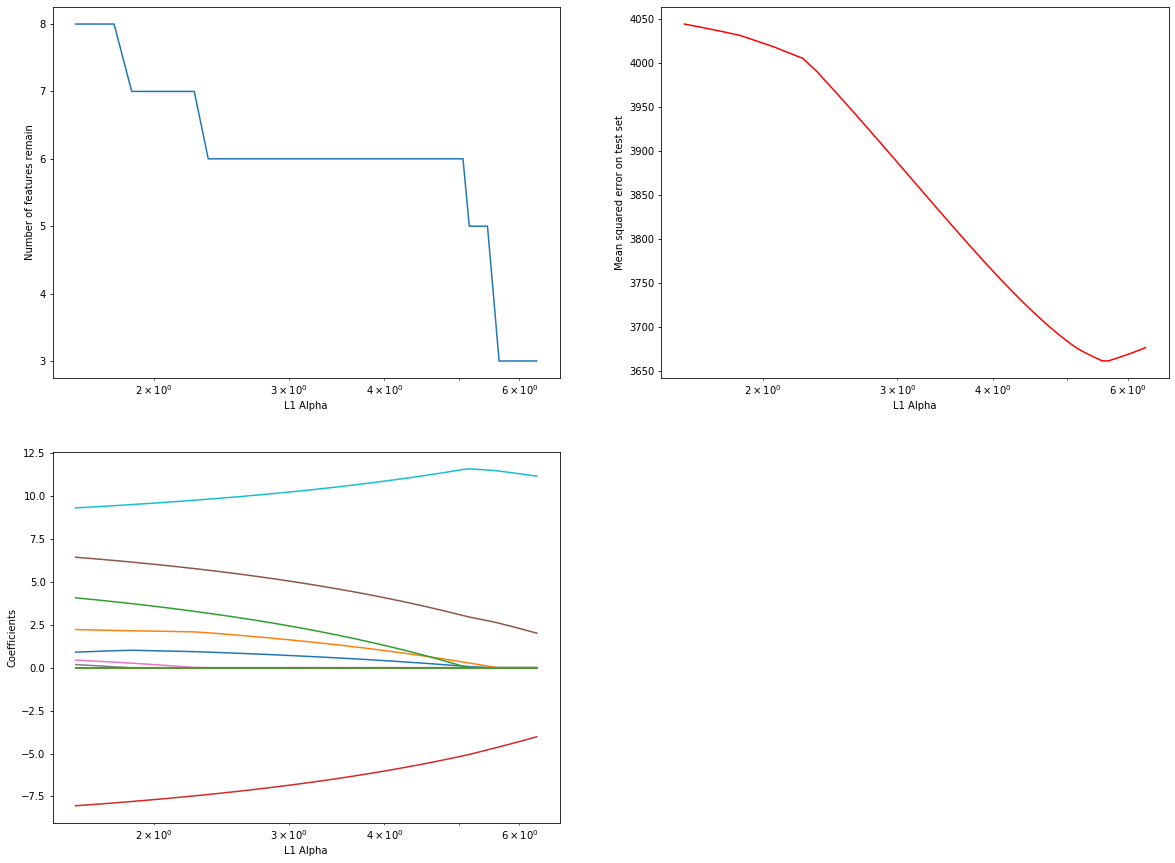

In [37]:
plt.figure(figsize=(20, 15))
plt.subplot(221)
plt.plot(l1_alphas, number_of_features_remain)
plt.xscale("log")
plt.xlabel("L1 Alpha")
plt.ylabel("Number of features remain")
plt.axis('tight')

plt.subplot(222)
plt.plot(l1_alphas, mses, color="red")
plt.xscale("log")
plt.xlabel("L1 Alpha")
plt.ylabel("Mean squared error on test set")
plt.axis('tight')

plt.subplot(223)
plt.plot(l1_alphas, features_coef_remain)
plt.xscale("log")
plt.xlabel("L1 Alpha")
plt.ylabel("Coefficients")
plt.axis('tight')
plt.show()

### Build a model strictly with the selected features
Remember that when you do features selecting, you may have to re-add bias into the list of features yet again. Use the selected features to build a model and calculate the performance basing on the metrics.

In [38]:
if("bias" not in lasso_selected_features):
    lasso_selected_features.append('bias')

scaler = StandardScaler()
train_features = scaler.fit_transform(train_data[ lasso_selected_features ].values)
test_features = scaler.transform(test_data[ lasso_selected_features ].values)

multi_model = LinearRegression().fit(train_features, train_labels)

test_predictions = multi_model.predict(test_features)
mse_test = mean_squared_error(test_labels, test_predictions)
mse_train = mean_squared_error(train_labels, multi_model.predict(train_features))
print("Train MSE: {:.4f}, Test MSE: {:.4f}".format(mse_train, mse_test))

Train MSE: 1551.2728, Test MSE: 3650.1404


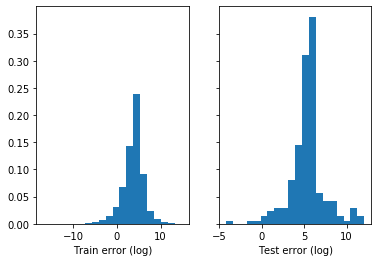

In [39]:
train_square_errors = np.log( (train_labels - multi_model.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()

## Combine everything on one model
So LASSO performed admirably, shrinking aways unnecessary and noisy features and quicken the speed of calculation. Now let us combine both previous techniques together on one model.

In [40]:
l2_alphas = np.logspace(-10, 10)
return_data = []

for l2_alpha in l2_alphas:
    multi_model = Ridge(alpha=l2_alpha).fit(train_features, train_labels)
    return_data.append([mean_squared_error(test_labels, multi_model.predict(test_features)), 
                       mean_squared_error(train_labels, multi_model.predict(train_features)), multi_model])
multi_model = sorted(return_data)[0][2] # sort the return data based on test MSE by ascending order
test_predictions = multi_model.predict(test_features)
print("Train MSE: {:.4f}, Test MSE: {:.4f}".format(sorted(return_data)[0][1], sorted(return_data)[0][0]))

Train MSE: 1556.9672, Test MSE: 3627.9486


### Distribution of square errors
The conclusion is yours to draw. As a side note, let's see how the square errors are distributed.

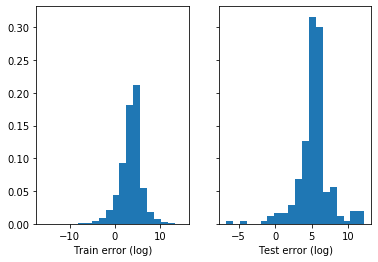

In [41]:
train_square_errors = np.log( (train_labels - multi_model.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()